In [1]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt,Warped_EI_acquisition_opt
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class GP_ObjectiveFunction:  
    def __init__(self,dim=2,lengthscale=0.1,variance=10,seed=0):
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.init_num = 8**dim

      np.random.seed(seed) 

      X_start = np.random.uniform(self.npbounds[:, 0], self.npbounds[:, 1],size=(1,dim))
      temp = float(np.random.normal(0, 1, size=1))
      Y_start=np.array([[temp]])

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_start = GPy.models.GPRegression(X_start,Y_start,kernel)
      m_start.Gaussian_noise.variance.fix(0.0)

      X_init = np.random.uniform(self.npbounds[:, 0], self.npbounds[:, 1],size=(self.init_num ,dim))
      Y_init = m_start.posterior_samples_f(X_init.reshape(-1,dim),size=1)

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_init = GPy.models.GPRegression(X_init.reshape(-1,dim),Y_init.reshape(-1,1),kernel)
      m_init.Gaussian_noise.variance.fix(0.0)

      self.GP = m_init



    def __call__(self, X):

        X = X.numpy()

        mean,_ = self.GP.predict(X.reshape(-1,self.dim),include_likelihood=False)

        return mean

In [2]:
def high_dimensional_discretization(bounds,N=800): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [4]:
fun = GP_ObjectiveFunction(dim=2,lengthscale=0.1,variance=10,seed=0)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

max output is  -5.244885387590629


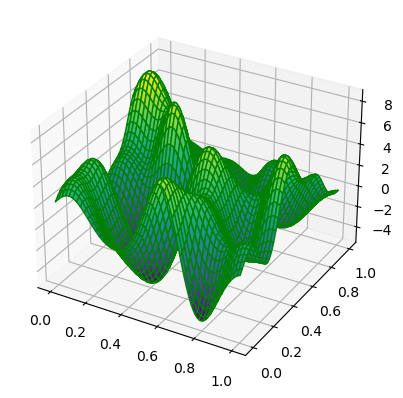

In [5]:
X_total = torch.tensor(high_dimensional_discretization(np.array([[0,1],[0,1]]),N=250))
Y_total = fun(X_total).reshape(250,250)

print('max output is ',np.min(Y_total))

X1 = np.linspace(0,1,250)
X2 = np.linspace(0,1,250)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total, cmap ='viridis', edgecolor ='green')

plt.show()

In [6]:
n_init = 3*dim
iter_num = 6*dim
N = 30

fstar = np.min(Y_total)
fun = Trans_function(fun,fstar,min=True)

In [7]:
BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, torch.tensor(Y_next)), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record)
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [8]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp
    

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0.
    

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

            #print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, torch.tensor(Y_next)), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [9]:
Warped_BO_TEI2 = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, torch.tensor(Y_next)), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI2.append(best_record)

0
0
1
2
3
4
5
6
7
8
9
10
11
1
0
1
2
3
4
5
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with scipy.minimize!
issue with sc

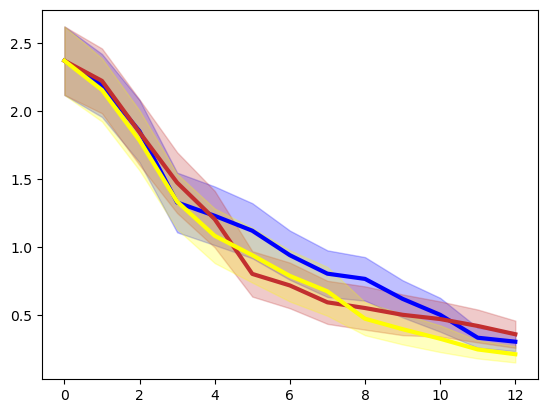

In [10]:
N = 30

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(BO_MES)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log GP +TEI2',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

# e^g(x)-c

In [55]:
class logGP_ObjectiveFunction:  
    def __init__(self,dim=2,lengthscale=0.1,variance=10,seed=0):
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.init_num = 15**dim

      np.random.seed(seed) 

      X_start = np.random.uniform(self.npbounds[:, 0], self.npbounds[:, 1],size=(1,dim))
      temp = float(np.random.normal(0, 1, size=1))
      Y_start=np.array([[temp]])

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_start = GPy.models.GPRegression(X_start,Y_start,kernel)
      m_start.Gaussian_noise.variance.fix(10**(-6))

      X_init = np.random.uniform(self.npbounds[:, 0], self.npbounds[:, 1],size=(self.init_num ,dim))
      Y_init = m_start.posterior_samples_f(X_init.reshape(-1,dim),size=1)

      kernel = GPy.kern.RBF(input_dim=dim,variance=variance,lengthscale=lengthscale)
      m_init = GPy.models.GPRegression(X_init.reshape(-1,dim),Y_init.reshape(-1,1),kernel)
      m_init.Gaussian_noise.variance.fix(10**(-6))

      self.GP = m_init



    def __call__(self, X):

        X = X.numpy()

        mean,_ = np.exp(self.GP.predict(X.reshape(-1,self.dim),include_likelihood=False))

        return mean

In [56]:
l=0.1
var = 1.

In [57]:
fun = logGP_ObjectiveFunction(dim=2,lengthscale=l,variance=var,seed=12345)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

min output is  0.02349447273724647


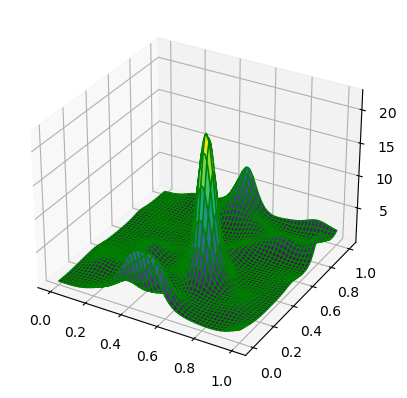

In [58]:
X_total = torch.tensor(high_dimensional_discretization(np.array([[0,1],[0,1]]),N=500))
Y_total = fun(X_total).reshape(500,500)

print('min output is ',np.min(Y_total))

fstar = np.min(Y_total)

X1 = np.linspace(0,1,500)
X2 = np.linspace(0,1,500)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total, cmap ='viridis', edgecolor ='green')

plt.show()

In [59]:
fun = logGP_ObjectiveFunction(dim=2,lengthscale=l,variance=var,seed=12345)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
fun = Trans_function(fun,0.,min=True)

n_init = 5
iter_num = 8*dim
N = 25

In [60]:
Warped_BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = X_BO.numpy()
            
            # train the GP
            lengthscale = l
            variance = var
            c = 0.
        
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = 0. #np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = torch.tensor(standard_next_X).reshape(-1,dim)           
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, torch.tensor(Y_next)), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)         
    Warped_BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [61]:
Warped_BO_standardEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = X_BO.numpy()
            
            # train the GP
            lengthscale = l
            variance = var
            c = 0.0
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = 0. 
            warp_Y_standard = warp_Y-mean_warp_Y
            
            minimal = np.min(warp_Y_standard)
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))
            
            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = torch.tensor(standard_next_X).reshape(-1,dim)          
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, torch.tensor(Y_next)), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)         
    Warped_BO_standardEI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


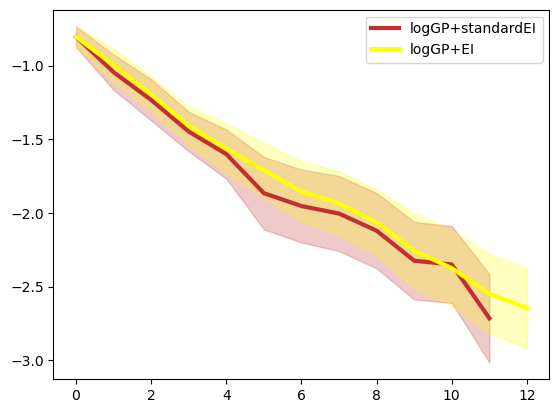

In [62]:
N = 25

total_record = np.log10(np.array(Warped_BO_standardEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+standardEI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')


total_record = np.log10(np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.legend()